In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, auc,  accuracy_score, log_loss, confusion_matrix
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier

In [2]:
# Load the dataset
df = pd.read_csv("stroke-data.csv")
print(df.isnull().sum())

# Impute missing BMI values (or you can drop them if very few)
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [3]:
# Convert categorical variables
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    df[col] = df[col].astype('category')

/tmp/ipykernel_2413078/1890546674.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=df, palette='Set2')


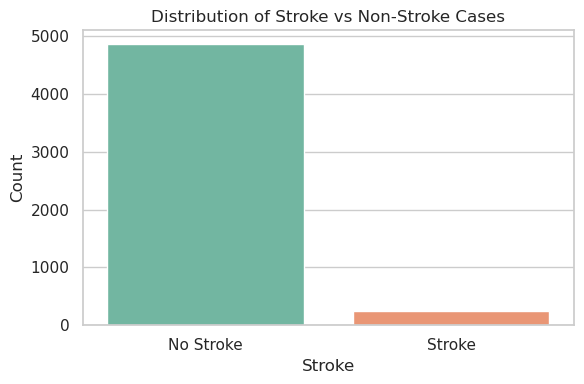

In [4]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.countplot(x='stroke', data=df, palette='Set2')
plt.title('Distribution of Stroke vs Non-Stroke Cases')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.tight_layout()
plt.show()

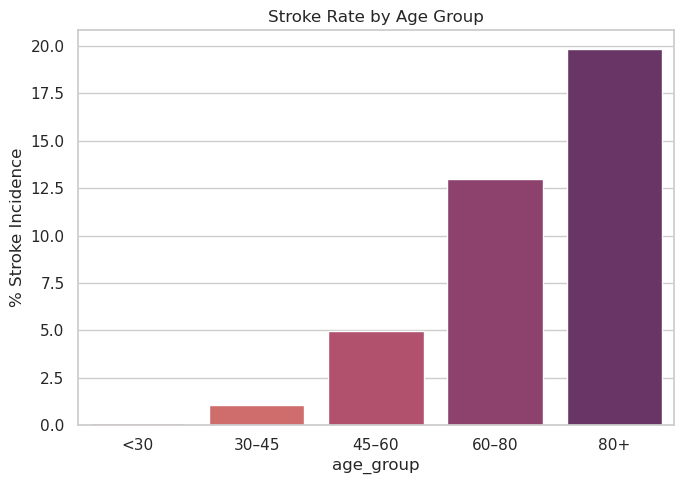

In [5]:
# Create age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 45, 60, 80, 100],
                         labels=['<30', '30–45', '45–60', '60–80', '80+'])
plt.figure(figsize=(7,5))
sns.barplot(x='age_group', y='stroke', hue = 'age_group', data=df, estimator=lambda x: sum(x)/len(x)*100, errorbar=None, palette='flare')
plt.ylabel('% Stroke Incidence')
plt.title('Stroke Rate by Age Group')
plt.tight_layout()
plt.show()


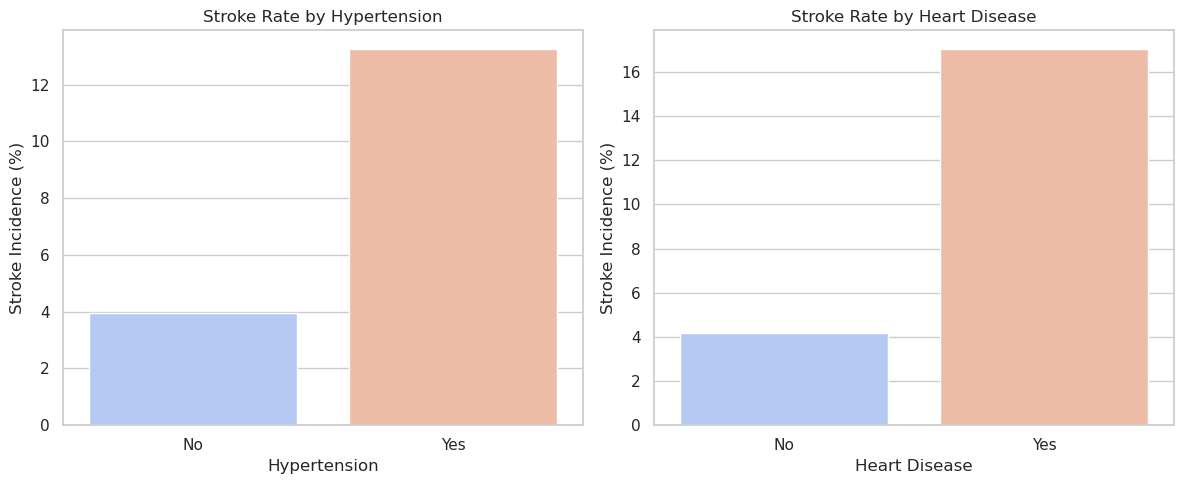

In [6]:
plt.figure(figsize=(12, 5))

# Hypertension subplot
plt.subplot(1, 2, 1)
sns.barplot(
    x='hypertension',
    y='stroke',
    hue='hypertension',
    data=df,
    estimator=lambda x: sum(x)/len(x)*100,
    errorbar=None,
    palette='coolwarm',
    legend=False
)
plt.title('Stroke Rate by Hypertension')
plt.xlabel('Hypertension')
plt.ylabel('Stroke Incidence (%)')
plt.xticks([0, 1], ['No', 'Yes'])

# Heart disease subplot
plt.subplot(1, 2, 2)
sns.barplot(
    x='heart_disease',
    y='stroke',
    hue='heart_disease',
    data=df,
    estimator=lambda x: sum(x)/len(x)*100,
    errorbar=None,
    palette='coolwarm',
    legend=False
)
plt.title('Stroke Rate by Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Stroke Incidence (%)')
plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout()
plt.show()

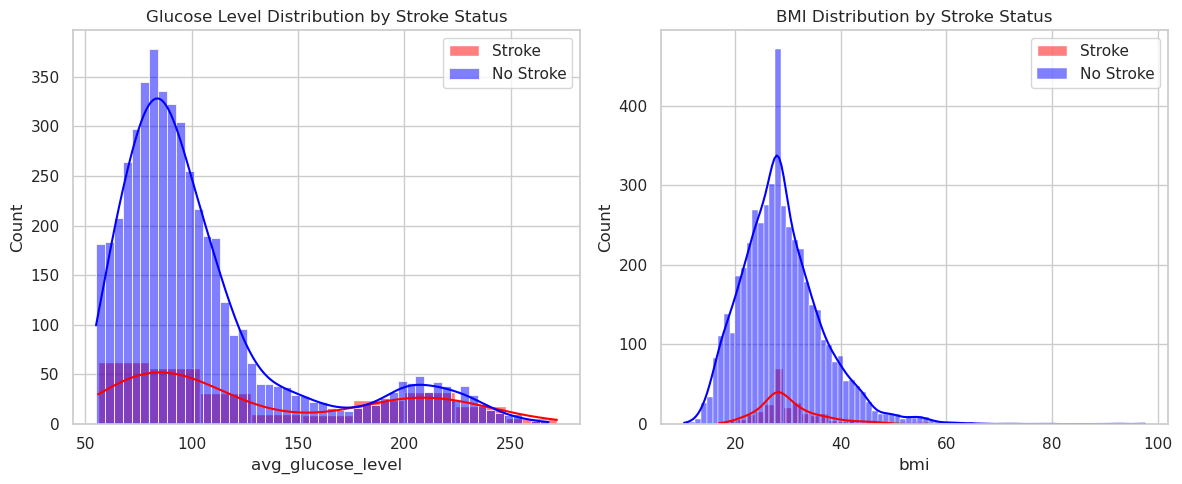

In [7]:
# Glucose
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(df[df['stroke']==1]['avg_glucose_level'], kde=True, color='red', label='Stroke')
sns.histplot(df[df['stroke']==0]['avg_glucose_level'], kde=True, color='blue', label='No Stroke')
plt.legend()
plt.title('Glucose Level Distribution by Stroke Status')

# BMI
plt.subplot(1, 2, 2)
sns.histplot(df[df['stroke']==1]['bmi'], kde=True, color='red', label='Stroke')
sns.histplot(df[df['stroke']==0]['bmi'], kde=True, color='blue', label='No Stroke')
plt.legend()
plt.title('BMI Distribution by Stroke Status')

plt.tight_layout()
plt.show()

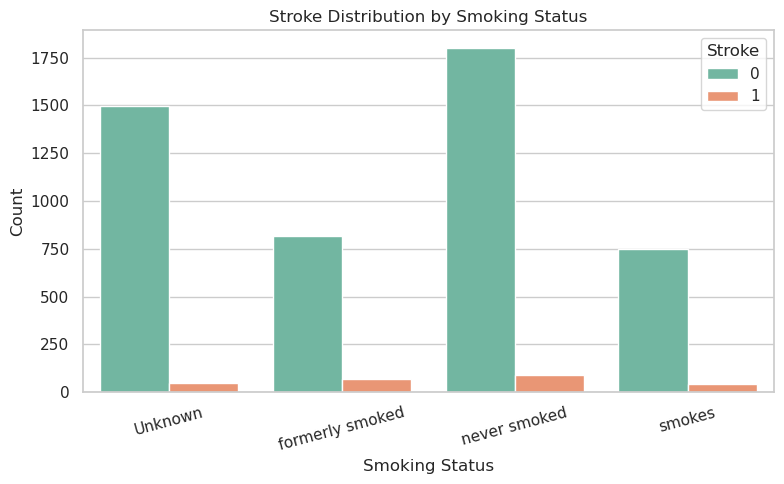

In [47]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='smoking_status', hue='stroke', palette='Set2')

plt.title('Stroke Distribution by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.legend(title='Stroke')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [43]:
# Step 1: Feature and target
X = df.drop(columns=['stroke','id'])
y = df['stroke']
X = pd.get_dummies(X, drop_first=True)

# Step 2: Train-test split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: SMOTE on training only
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 4: Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 5: Model training
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', scale_pos_weight=10, random_state=42)
}

# Step 6: Fit and predict with threshold tuning
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_resampled)
    probs = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    #best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresh = 0.3
    y_pred = (probs > best_thresh).astype(int)

    report = classification_report(y_test, y_pred, output_dict=True)['1']
    results[name] = {
        'Precision': report['precision'],
        'Recall': report['recall'],
        'F1 Score': report['f1-score'],
        'AUC': roc_auc_score(y_test, probs),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Log Loss': log_loss(y_test, probs),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Best Threshold': best_thresh
    }
print(f"Best threshold for F1: {best_thresh:.2f}")
# Summary
summary_df = pd.DataFrame({
    model: {
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1 Score': metrics['F1 Score'],
        'AUC': metrics['AUC'],
        'Accuracy': metrics['Accuracy'],
        'Log Loss': metrics['Log Loss'],
        'Best Threshold': metrics['Best Threshold']
    }
    for model, metrics in results.items()
}).T.round(3)

summary_df


Best threshold for F1: 0.30


,Precision,Recall,F1 Score,AUC,Accuracy,Log Loss,Best Threshold
Logistic Regression,0.124,0.64,0.208,0.782,0.761,0.307,0.3
Random Forest,0.126,0.28,0.174,0.780,0.870,0.244,0.3
XGBoost,0.148,0.32,0.203,0.805,0.877,0.269,0.3


In [32]:
X_clean = X_clean.apply(pd.to_numeric, errors='coerce')
y_clean = pd.to_numeric(y_clean, errors='coerce')

# Drop rows with any NaNs
valid_index = X_clean.dropna().index.intersection(y_clean.dropna().index)
# Drop rows with any NaNs
valid_index = X_clean.dropna().index.intersection(y_clean.dropna().index)

X_ready = X_clean.loc[valid_index]
y_ready = y_clean.loc[valid_index]

X_ready = X_ready.astype({col: int for col in X_ready.select_dtypes('bool').columns})
X_ready = X_ready.astype(float)

In [33]:
print(X_ready)

      const   age  hypertension  heart_disease  avg_glucose_level   bmi  \
845     1.0  48.0           0.0            0.0              69.21  33.1   
3744    1.0  15.0           0.0            0.0             122.25  21.0   
4183    1.0  67.0           0.0            0.0             110.42  24.9   
3409    1.0  44.0           0.0            0.0              65.41  24.8   
284     1.0  14.0           0.0            0.0              82.34  31.6   
...     ...   ...           ...            ...                ...   ...   
1434    1.0  45.0           0.0            0.0              92.86  35.1   
461     1.0  16.0           0.0            0.0             113.47  19.5   
1052    1.0  61.0           0.0            0.0              78.65  36.2   
1757    1.0  31.0           0.0            0.0              74.05  26.0   
5052    1.0   6.0           0.0            0.0              91.05  22.1   

      gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
845           0.0     

In [34]:
print(X_ready.dtypes)

const                             float64
age                               float64
hypertension                      float64
heart_disease                     float64
avg_glucose_level                 float64
bmi                               float64
gender_Male                       float64
gender_Other                      float64
ever_married_Yes                  float64
work_type_Never_worked            float64
work_type_Private                 float64
work_type_Self-employed           float64
work_type_children                float64
Residence_type_Urban              float64
smoking_status_formerly smoked    float64
smoking_status_never smoked       float64
smoking_status_smokes             float64
age_group_30–45                   float64
age_group_45–60                   float64
age_group_60–80                   float64
age_group_80+                     float64
dtype: object


In [35]:
logit_model = sm.Logit(y_ready, sm.add_constant(X_ready))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.152814
         Iterations 26
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 4088
Model:                          Logit   Df Residuals:                     4067
Method:                           MLE   Df Model:                           20
Date:                Sun, 29 Jun 2025   Pseudo R-squ.:                  0.2148
Time:                        16:20:14   Log-Likelihood:                -624.70
converged:                       True   LL-Null:                       -795.55
Covariance Type:            nonrobust   LLR p-value:                 2.279e-60
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -41.3735   3.26e+06  -1.27e-05    

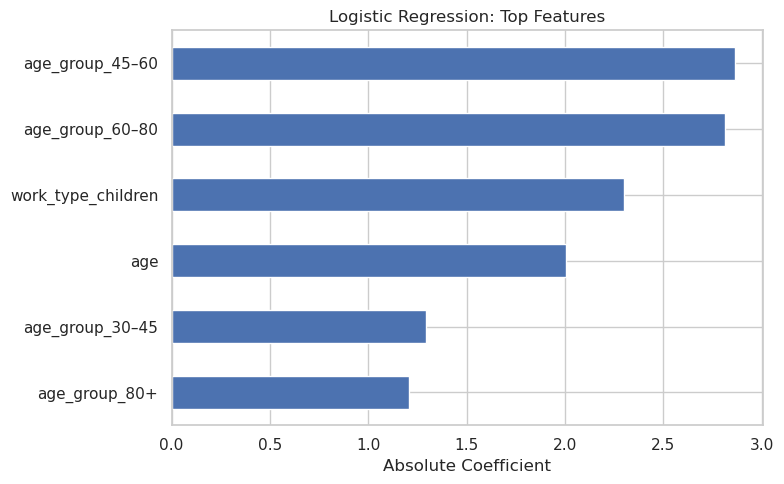

In [36]:
# Make sure to re-fit logistic regression on the scaled DataFrame if needed
# Re-define and fit the model
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
logreg.fit(X_train_scaled, y_resampled)
logreg.fit(X_train_scaled, y_resampled)

# Get coefficients and feature names
logreg_importance = pd.Series(
    np.abs(logreg.coef_[0]), 
    index=X.columns
).sort_values(ascending=False)

# Plot top 10
logreg_importance.head(6).plot(kind='barh', title='Logistic Regression: Top Features', figsize=(8, 5))
plt.gca().invert_yaxis()
plt.xlabel("Absolute Coefficient")
plt.tight_layout()
plt.show()

In [37]:


# 1. Fit logistic regression model
X_ready_with_const = sm.add_constant(X_ready)
logit_model = sm.Logit(y_ready, X_ready_with_const)
result = logit_model.fit()

# 2. Use wald_test_terms to get groupwise Wald statistics
wald_results = result.wald_test_terms(skip_single=False)

# 3. Display summary
print(wald_results)

Optimization terminated successfully.
         Current function value: 0.152814
         Iterations 26
                                                      chi2                  P>chi2  df constraint
const                            [[1.608428360694353e-10]]      0.9999898809224886              1
age                                  [[28.22623583901737]]  1.0793163842272333e-07              1
hypertension                         [[6.016934162430587]]    0.014169240361406198              1
heart_disease                       [[1.1972209093007493]]     0.27387783729143467              1
avg_glucose_level                    [[8.238503878306908]]    0.004101092353805262              1
bmi                                [[0.11860135564612198]]      0.7305564105621368              1
gender_Male                        [[0.08123237443212793]]        0.77563423028896              1
gender_Other                    [[5.3632612201150206e-18]]      0.9999999981522019              1
ever_married_Ye

/home/statgrads/achanda/.local/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [44]:
# Train LightGBM
lgb_model = lgb.LGBMClassifier(scale_pos_weight=10, random_state=42)
lgb_model.fit(X_resampled, y_resampled)

# Predict probabilities
probs_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_lgb)
pr_auc = auc(recall, precision)

# Find best threshold (maximize F1 score)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = f1_scores.argmax()
#best_threshold = thresholds[best_idx]
best_threshold = 0.3
# Predict with adjusted threshold
y_pred_lgb_adjusted = (probs_lgb > best_threshold).astype(int)

# Classification report
report_lgb = classification_report(y_test, y_pred_lgb_adjusted, output_dict=True)
report_lgb["AUC"] = roc_auc_score(y_test, probs_lgb)

# Print summary
summary = pd.DataFrame({
    'Precision': [report_lgb['1']['precision']],
    'Recall': [report_lgb['1']['recall']],
    'F1 Score': [report_lgb['1']['f1-score']],
    'AUC': [report_lgb['AUC']],
    'Best Threshold': [best_threshold]
}, index=['LightGBM (Adjusted Threshold)'])

print(summary.round(3))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3889, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 7778, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                               Precision  Recall  F1 Score    AUC  \
LightGBM (Adjusted Threshold)        0.0     0.0       0.0  0.464   

                               Best Threshold  
LightGBM (Adjusted Threshold)             0.3  


/home/statgrads/achanda/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/statgrads/achanda/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/statgrads/achanda/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3889, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 795
[LightGBM] [Info] Number of data points in the train set: 7778, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3889, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 795
[LightGBM] [I

/home/statgrads/achanda/.local/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/statgrads/achanda/.local/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/statgrads/achanda/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/statgrads/achanda/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

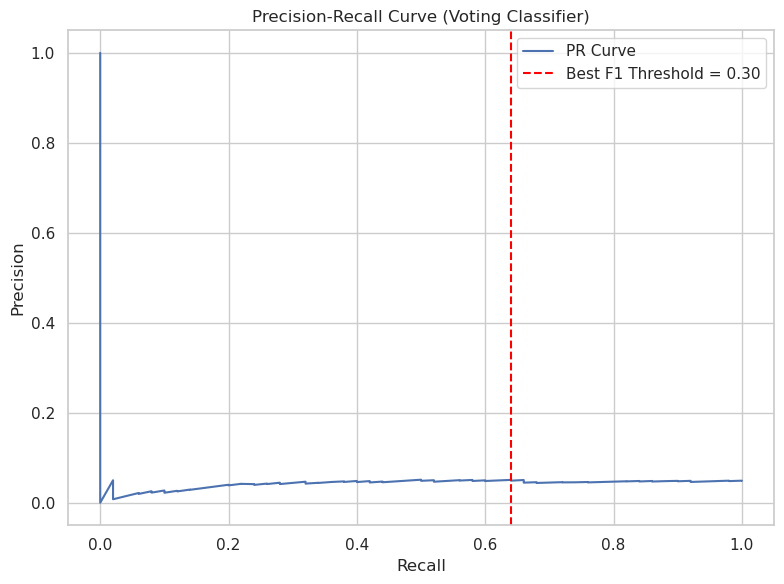

,Precision,Recall,F1 Score,AUC,Best Threshold
Ensemble Voting Classifier,0.0,0.0,0.0,0.628,0.3


In [46]:
# Define soft voting ensemble (uses predicted probabilities)

logreg =LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
logreg.fit(X_resampled,y_resampled)
rf= RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_resampled,y_resampled)
xgb= XGBClassifier(eval_metric='logloss', scale_pos_weight=10, random_state=42)
xgb.fit(X_resampled,y_resampled)
lgb_model = lgb.LGBMClassifier(scale_pos_weight=10, random_state=42)
lgb_model.fit(X_resampled, y_resampled)

ensemble = VotingClassifier(
    estimators=[
        ('Logistic Regression', logreg),
        ('Random Forest', rf),
        ('XGBoost', xgb),
        ('LightGBM', lgb_model)
    ],
    voting='soft'  # soft = based on predicted probabilities
)

# Train the ensemble model
ensemble.fit(X_resampled, y_resampled)

# Predict probabilities and then apply threshold
probs_ensemble = ensemble.predict_proba(X_test_scaled)[:, 1]

# Predict using best threshold
y_pred_ensemble = (probs_ensemble > best_threshold).astype(int)

# Report
report = classification_report(y_test, y_pred_ensemble, output_dict=True)
report["AUC"] = roc_auc_score(y_test, probs_ensemble)

# Create summary DataFrame
summary = pd.DataFrame({
    'Precision': [report['1']['precision']],
    'Recall': [report['1']['recall']],
    'F1 Score': [report['1']['f1-score']],
    'AUC': [report['AUC']],
    'Best Threshold': [best_threshold]
}, index=['Ensemble Voting Classifier'])

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve')
plt.axvline(recall[best_idx], linestyle='--', color='red', label=f'Best F1 Threshold = {best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Voting Classifier)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

summary.round(3)
